In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [5]:
htwt_df = pd.read_csv("data/01_heights_weights_genders.csv")
htwt_df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


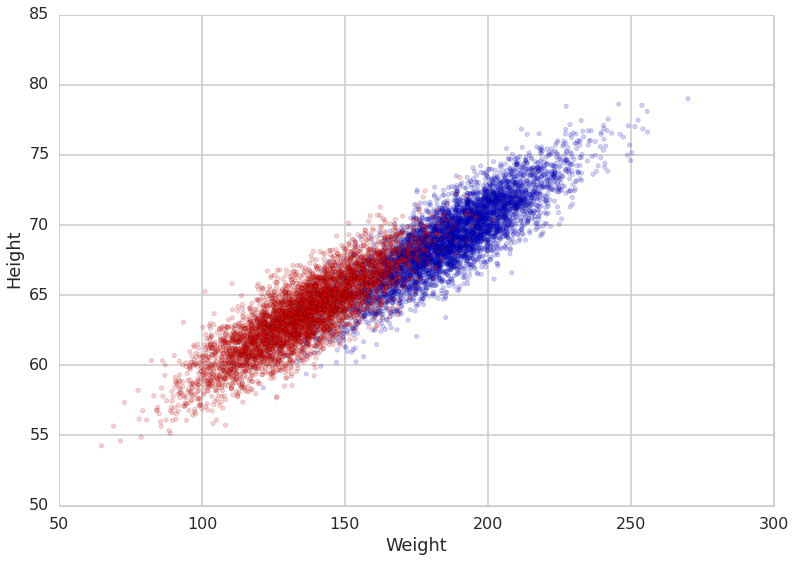

In [8]:
plt.scatter(htwt_df.Weight,htwt_df.Height,c=[cm_bright.colors[i] for i in htwt_df.Gender=="Male"],alpha=0.2)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

In [33]:
from sklearn.cross_validation import train_test_split
X = htwt_df[['Weight','Height']].values
Y = htwt_df[['Gender']].values
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [35]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def get_rmse(predicted,actual):
    return np.sqrt(np.sum((predicted - actual)**2)/len(actual))
    
def cv_score(clf,X,Y,score_func=accuracy_score):
    n = Y.size
    score = 0
    n_folds = 5
    for tr_index,te_index in KFold(n,n_folds=n_folds):
        X_train,Y_train = X[tr_index],Y[tr_index]
        X_test,Y_test = X[te_index],Y[te_index]
        clf.fit(X_train,Y_train)
        predicted = clf.predict(X_test)
        score = score + accuracy_score(predicted,Y_test)
    
    return score/n_folds

Cs=[0.001, 0.1, 1, 10, 100]
best_score = 0
best_c = 0

for c in Cs:
    clf = LogisticRegression(C=c)
    model_score = cv_score(clf,X_train,Y_train.ravel())
    if model_score > best_score:
        best_score = model_score
        best_c = c
        
print best_score,best_c

0.9188 1


In [38]:
#Now using best C obtained in previous step to make prediction on test-set
clf = LogisticRegression(C=best_c)
clf.fit(X_train,Y_train.ravel())
predicted = clf.predict(X_test)
accuracy_score(predicted,Y_test)

0.92079999999999995

In [90]:
##The ATM Camera example
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)
pca.explained_variance_ratio_
data_transformed = pca.transform(data)
data_transformed.shape

(87, 2)

In [92]:
X = (data_transformed - data_transformed.mean())/data_transformed.std()
Y = y.ravel()

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'), 1.0, 0.88571428571428568)
(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=50, p=2, weights='uniform'), 0.59615384615384615, 0.5714285714285714)


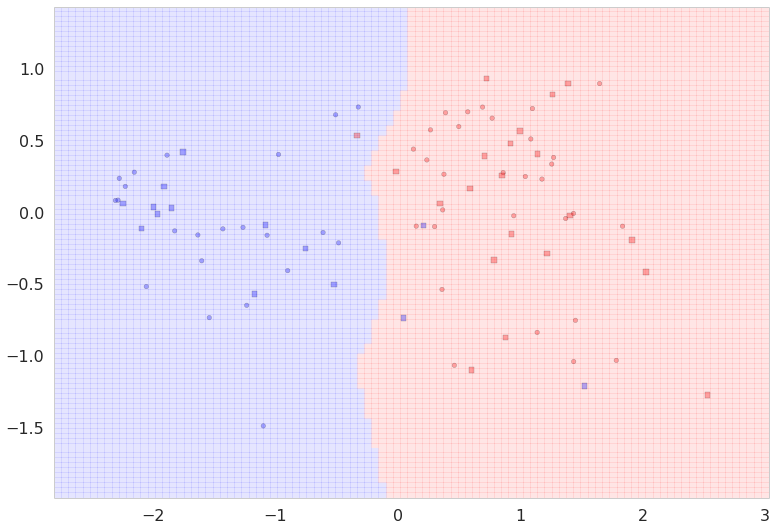

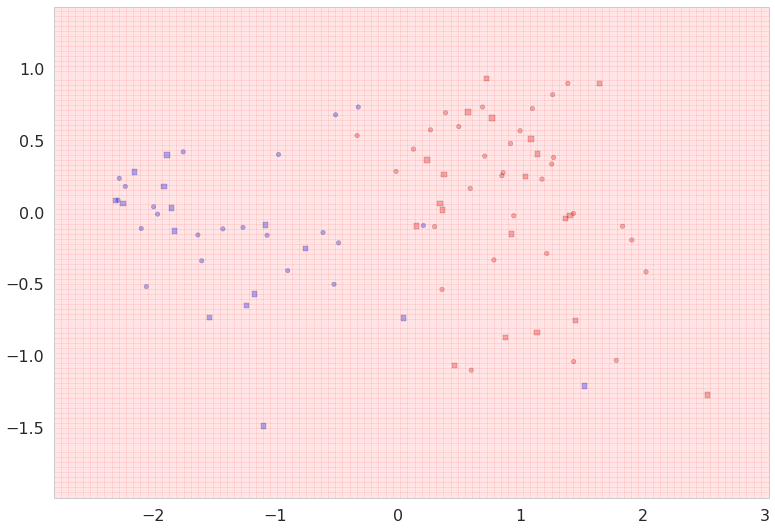

In [93]:
from sklearn.neighbors import KNeighborsClassifier

def do_classification(X,y,neigh,plot=False):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.6)
    nbrs = KNeighborsClassifier(n_neighbors=neigh)
    nbrs = nbrs.fit(X_train,Y_train)
    training_accuracy = nbrs.score(X_train,Y_train)
    test_accuracy = nbrs.score(X_test,Y_test)

    if plot == True:
        plt.figure()
        ax=plt.gca()
        points_plot(ax, X_train, X_test, Y_train, Y_test, nbrs, alpha=0.3, psize=20)
    
    return nbrs,training_accuracy,test_accuracy

print do_classification(X,Y,1,True)
print do_classification(X,Y,50,True)

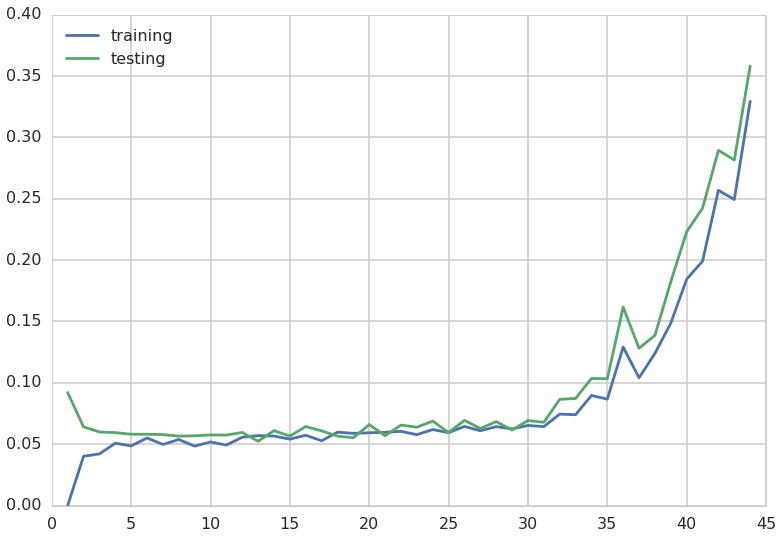

In [94]:
#Analysing error against complexity
models = {}
for k in np.arange(1,45,1):
    models[k] = []
    for i in range(200):
        models[k].append(do_classification(X,Y,k))

nbrs=np.arange(1,45,1)
mean_error_tr = []
mean_error_te = []
mean_std_tr = []
mean_std_te = []

for neigh in nbrs:
    training_error = []
    for t in models[neigh]:
        training_error.append(t[1])
    mean_error_tr.append(1.0-np.mean(training_error))

for neigh in nbrs:
    test_error = []
    for t in models[neigh]:
        test_error.append(t[1])
    mean_error_te.append(1.0-np.mean(test_error))
    
fstdsstr = np.array([np.std([t[1] for t in models[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in models[e]]) for e in nbrs])

#plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training")
plt.plot(nbrs, fmeanste, color=c1, label="testing")
plt.legend(loc=2)
plt.show()

In [96]:
#Now using grid-search for best estimation of K

from sklearn.grid_search import GridSearchCV

def get_best_estimator(clf,params,X,Y,cv=5):
    gs_clf = GridSearchCV(clf,param_grid=params,cv=cv)
    gs_clf.fit(X,Y)
    return gs_clf.best_estimator_

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.7)
param_grid ={'n_neighbors':np.arange(1,40,2)}
clf = get_best_estimator(KNeighborsClassifier(),param_grid,X_train,Y_train)
print "Accuracy on training set %f " % clf.score(X_train,Y_train)
print "Accuracy on testing set %f " % clf.score(X_test,Y_test)

Accuracy on training set 0.916667 
Accuracy on testing set 1.000000 


(<matplotlib.axes.AxesSubplot at 0x108217b10>,
 array([[-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258],
        [-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258],
        [-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258],
        ..., 
        [-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258],
        [-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258],
        [-2.81003782, -2.75103074, -2.69202367, ...,  2.91364843,
          2.97265551,  3.03166258]]),
 array([[-1.98089515, -1.98089515, -1.98089515, ..., -1.98089515,
         -1.98089515, -1.98089515],
        [-1.94630808, -1.94630808, -1.94630808, ..., -1.94630808,
         -1.94630808, -1.94630808],
        [-1.91172101, -1.91172101, -1.91172101, ..., -1.91172101,
         -1.91172101, -1.91172101],
        ..., 
     

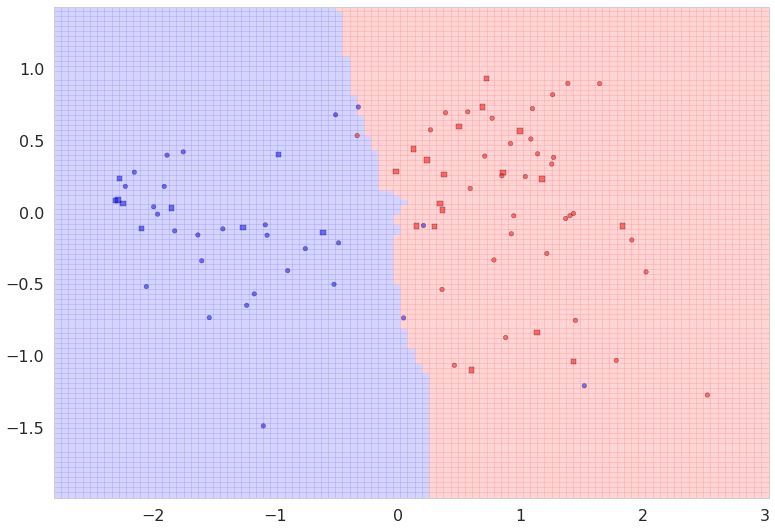

In [97]:
plt.figure()
ax=plt.gca()
points_plot(ax, X_train, X_test, Y_train, Y_test, clf, alpha=0.5, psize=20)

In [98]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix(Y_test,clf.predict(X_test))

array([[18,  0],
       [ 0,  9]])

In [103]:
#Using Logistic Regression for classification

X = htwt_df[['Weight','Height']].values
Y = htwt_df[['Gender']].values
Y = np.array([1 if y == "Male" else 0 for y in Y])

X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X,Y,train_size=0.7)
param_grid ={"C": [0.01, 0.1, 1, 10, 100]}
clf1 = get_best_estimator(LogisticRegression(),param_grid,X_train1,Y_train1)
print "Accuracy on training set %f " % clf.score(X_train1,Y_train1)
print "Accuracy on testing set %f " % clf.score(X_test1,Y_test1)

Accuracy on training set 0.919714 
Accuracy on testing set 0.919000 


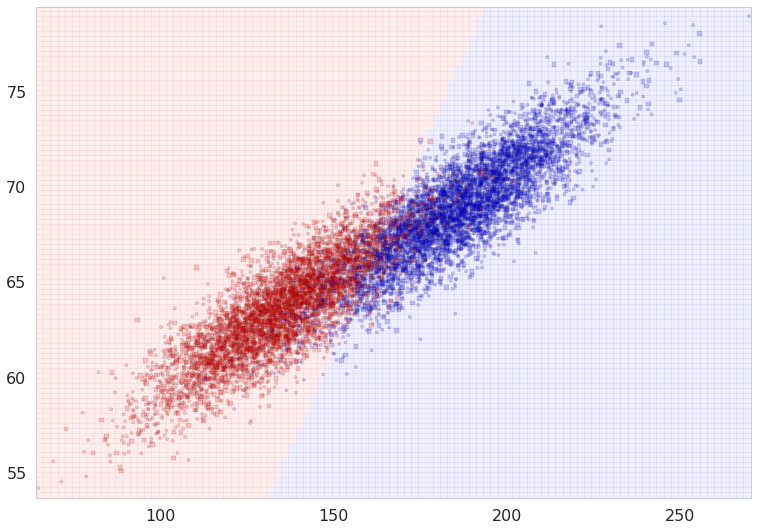

In [104]:
plt.figure()
ax=plt.gca()
points_plot(ax, X_train1, X_test1, Y_train1, Y_test1, clf1, alpha=0.2);

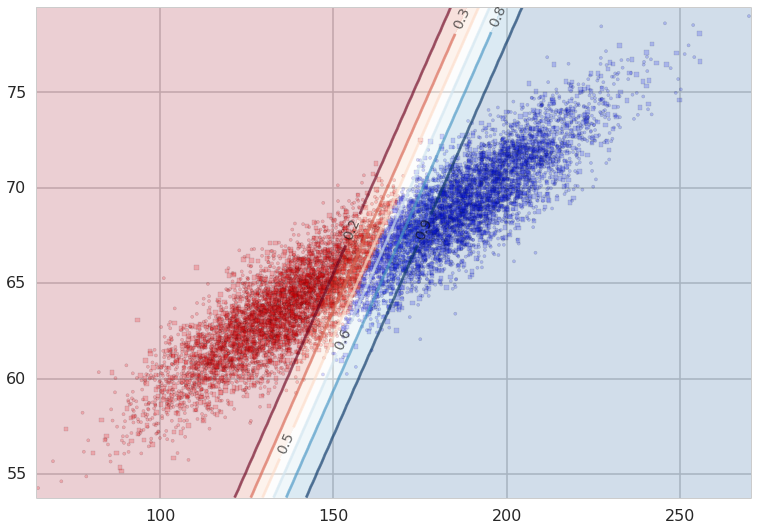

In [105]:
#Now plotting probability
plt.figure()
ax=plt.gca()
points_plot_prob(ax, X_train1, X_test1, Y_train1, Y_test1, clf1, alpha=0.2);